In [50]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [51]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [52]:
pl.style.use('fabiostyle')
# pl.rcParams['savefig.dpi'] = 300 # dpi for most publications
# pl.rcParams['xtick.labelsize'] = 7
# pl.rcParams['ytick.labelsize'] = 7
# pl.rcParams['axes.labelsize'] = 7
# pl.rcParams['axes.titlesize'] = 5
# pl.rcParams['legend.fontsize'] = 5
# pl.rcParams['xtick.labelsize'] = 5
# pl.rcParams['ytick.labelsize'] = 5
# pl.rcParams['font.size'] = 7

# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [69]:
NOTEBOOK_NAME = 'decoding_combined_vhpc_sh_csm'

In [54]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
# load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [55]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [56]:
all_animals = 'dhpcg1','dhpcg20','dhpc24'
pre_animals = 'dhpcg1','dhpcg20','dhpc24'
post_animals = 'dhpcg1','dhpcg20','dhpc24'
pre_rev_animals = 'dhpcg1','dhpcg20','dhpc24'
post_rev_animals = 'dhpcg1','dhpcg20','dhpc24'

epochs = '', '_early', '_mid', '_late'
sessions = 'pre','post','pre_rev','post_rev',

In [57]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within(patterns, labels, n_cells=None):
#     which_train = range(90)
#     which_test = range(90)
    cv =LeaveOneOut()
    
    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_train_a = np.random.permutation(np.where(np.array(labels[ani])==0)[0])
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        which_train_b = np.random.permutation(np.where(np.array(labels[ani])==1)[0])
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    patterns_T = patterns.copy()
    labels_T = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = np.array(labels[ani])[which_train[ani]]
        patterns_T[ani] = patterns[ani][which_test[ani]]
        labels_T[ani] = np.array(labels[ani])[which_test[ani]]
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    decoder.fit(patterns_comb_train, labels_comb)
    return decoder.score(patterns_comb_test, labels_comb)

In [58]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [59]:
sess_without = 'pre','post','pre_rev','post_rev',
sessions = '3odor_pre','3odor_post','3odor_pre_rev','3odor_post_rev',
for i in range(len(sessions)):

    exec("patterns_CS_%s = dict(zip(%s_animals, [ut.load_variable('patterns_evs',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_odors_sh_csm/'%%ani)\
                                                  for ani in %s_animals]))"%(sess_without[i], sess_without[i], sessions[i], sess_without[i]))
    exec("labels_CS_%s = dict(zip(%s_animals, [ut.load_variable('labels',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_odors_sh_csm/'%%ani)\
                                                  for ani in %s_animals]))"%(sess_without[i], sess_without[i], sessions[i], sess_without[i]))

In [60]:
sessions = 'pre','post','pre_rev','post_rev',

scores_CS = {}
n_loops = 100
for sess in sessions:
    scores_CS[sess] = np.r_[[do_test_within(eval("patterns_CS_%s"%sess), eval("labels_CS_%s"%sess))
                          for i in range(n_loops)]]

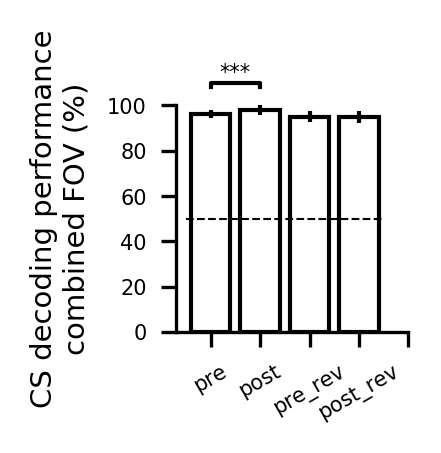

In [61]:
fig, ax = pl.subplots(1, 1, figsize=(1, 1))
values = [scores_CS[sess]*100 for sess in sessions]
pt.plot_bars(values, ax=ax)
ax.hlines(50, -0.5, len(sessions)-0.5, linestyles='dashed')

ax.set_xticks(range(5))
ax.set_xticklabels(sessions, rotation=30)
ax.set_ylabel('CS decoding performance\ncombined FOV (%)')
ax.set_ylim(0,100)

pvs = []
pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 110))

#fig.savefig('../img/%s__bars_CS.pdf'%NOTEBOOK_NAME)
#np.savetxt('../img/%s__bars_CS.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')

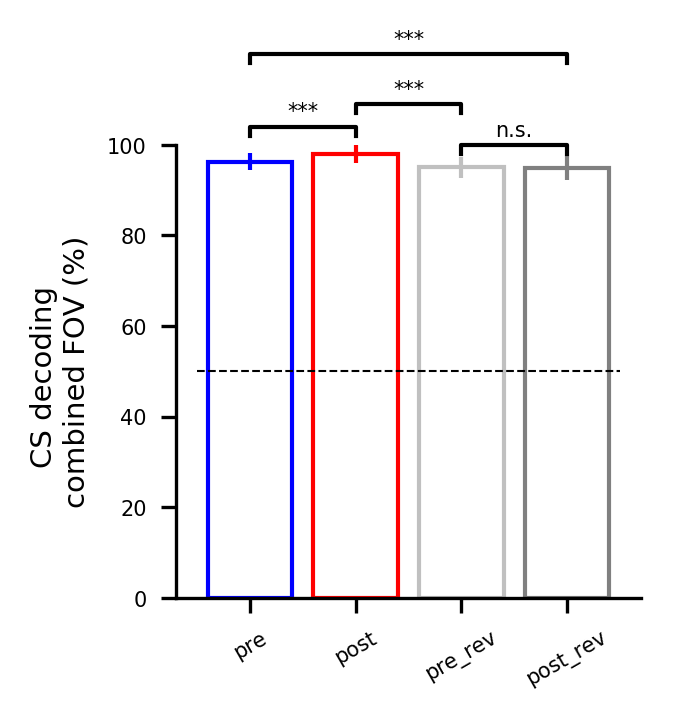

In [62]:
fig, ax = pl.subplots(1, 1, figsize=(2, 2))
sessionsb = 'pre','post','pre_rev','post_rev',
values = [scores_CS[sess]*100 for sess in sessions]
pt.plot_bars(values, ax=ax, colors = ['b','r','silver','grey',])
ax.hlines(50, -0.5, len(sessionsb)-0.5, linestyles='dashed')

ax.set_xticks(range(4))
ax.set_xticklabels(sessionsb, rotation=30)
ax.set_ylabel('CS decoding \ncombined FOV (%)')
ax.set_ylim(0,100)
pvs = []
pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]
pvs.append(pt.add_significance(ax, values[1], values[2], 1, 2, 109))
pvs.append(pt.add_significance(ax, values[2], values[3], 2, 3, 100))
pvs.append(pt.add_significance(ax, values[0], values[3], 0, 3, 120))


fig.savefig('../img/%s__bars_CS.pdf'%NOTEBOOK_NAME)
np.savetxt('../img/%s__bars_CS.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')

In [70]:
sess_without = 'pre','post','pre_rev','post_rev',
sessions = '3odor_pre','3odor_post','3odor_pre_rev','3odor_post_rev',
for i in range(len(sessions)):

    exec("patterns_%s = dict(zip(%s_animals, [ut.load_variable('patterns_evs',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_odors_only_trace_sh_csm/'%%ani)\
                                                  for ani in %s_animals]))"%(sess_without[i], sess_without[i], sessions[i], sess_without[i]))
    exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/%s/notebooks/autorestore/decoding_odors_only_trace_sh_csm/'%%ani)\
                                                  for ani in %s_animals]))"%(sess_without[i], sess_without[i], sessions[i], sess_without[i]))

In [71]:
sessions = 'pre','post','pre_rev','post_rev',

scores = {}
n_loops = 100
for sess in sessions:
    scores[sess] = np.r_[[do_test_within(eval("patterns_%s"%sess), eval("labels_%s"%sess))
                          for i in range(n_loops)]]

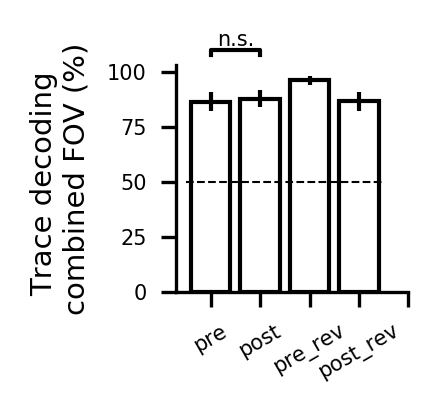

In [72]:
fig, ax = pl.subplots(1, 1, figsize=(1, 1))
values = [scores[sess]*100 for sess in sessions]
pt.plot_bars(values, ax=ax)
ax.hlines(50, -0.5, len(sessions)-0.5, linestyles='dashed')

ax.set_xticks(range(5))
ax.set_xticklabels(sessions, rotation=30)
ax.set_ylabel('Trace decoding \ncombined FOV (%)')

pvs = []
pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 110))

#fig.savefig('../img/%s__bars.pdf'%NOTEBOOK_NAME)
#np.savetxt('../img/%s__bars.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')

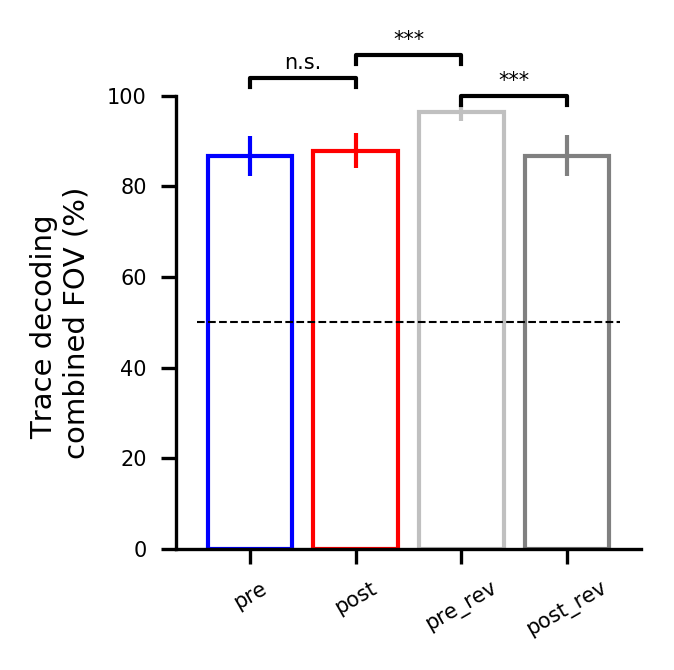

In [73]:
fig, ax = pl.subplots(1, 1, figsize=(2, 2))
sessionsb = 'pre','post','pre_rev','post_rev'
values = [scores[sess]*100 for sess in sessions]
pt.plot_bars(values, ax=ax, colors = ['b','r','silver','grey',])
ax.hlines(50, -0.5, len(sessionsb)-0.5, linestyles='dashed')

ax.set_xticks(range(4))
ax.set_xticklabels(sessionsb, rotation=30)
ax.set_ylabel('Trace decoding \ncombined FOV (%)')
ax.set_ylim(0,100)
pvs = []
pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]
pvs.append(pt.add_significance(ax, values[1], values[2], 1, 2, 109))
pvs.append(pt.add_significance(ax, values[2], values[3], 2, 3, 100))
#pvs.append(pt.add_significance(ax, values[3], values[4], 3, 4, 106))
#pvs.append(pt.add_significance(ax, values[0], values[4], 0, 4, 120))


fig.savefig('../img/%s__bars.pdf'%NOTEBOOK_NAME)
np.savetxt('../img/%s__bars.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')

In [74]:
total_cells_pre = sum(len(patterns_pre[ani][0]) for ani in pre_animals)
print 'total_cells_pre = ',
print total_cells_pre

total_cells_post = sum(len(patterns_post[ani][0]) for ani in post_animals)
print 'total_cells_post = ',
print total_cells_post

total_cells_pre_rev = sum(len(patterns_pre_rev[ani][0]) for ani in pre_rev_animals)
print 'total_cells_pre_rev = ',
print total_cells_pre_rev

total_cells_post_rev = sum(len(patterns_post_rev[ani][0]) for ani in post_rev_animals)
print 'total_cells_post_rev = ',
print total_cells_post_rev

total_cells_pre =  790
total_cells_post =  909
total_cells_pre_rev =  919
total_cells_post_rev =  703


In [75]:
save_workspace(db)

Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'di'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
